# <center> House Prices in Seattle: Spatial Analysis and Predictions

## I. Introduction

Real estate data is highly related to spatial pattern. If we want to fit real estate data to regression models to predict price of property, we normally need to fit our models by stratify the data into spatial levels. In this report, I will create a data-driven valuation model for the housing market for Seattle. I will explore different regression models with increasing complexity to define a valuation model and compare the spatial model to normal regression model to tell whether we can model sale price of the homes with a purely data-driven approach. Fist, I will use the simplest model which is Linear Regression as baseline. Next, I will use Geographically Weighted Regression. Finally, I will use Random Forest Regression.

## II. Literature review 
The GWR model defines a spatial model for home sale price and represents the hedonic model for sale price (Can, 1992) with geographically varying weights. Through applying spatial statistical analysis, the relationship between the effects of various factors and spatial distribution of residential house price are better to be figured out. Traditional regression models are without the consideration of spatial characteristics cannot reach very nice precision to simulate the spatial distribution of the house price. When considering these factors such as the land price, transportation, the distance to the commercial centre, and applying GWR, the result is much better than standard linear regression. It is demonstrated that GWR provides an effective model to present the distribution of the residential house price and serve as a tool for house price appraisal during the property tax levy process. (Jijin,2011)
Normally, the Euclidean distance is the default metric for calibrating a GWR model in previous research and applications (Lu,2011); In Binbin’s study, a GWR model is built to commit insights about spatially varying relationships between price and square feet of houses in London. The result is a fixed kernel makes a significant improvement.
Normally, the geographically weighted regression (GWR) model cannot put temporal issues into account, which means GWR has better been incorporated with time series effects, which named an extended GWR model, to deal with both spatial and temporal non stationarity real estate market data. (Bo,2008) Real estate data has temporal heterogeneity behaviour. Standard GWR model has hard time to deal with this kind of trait. There should have substantial benefits in modelling both spatial and temporal non stationarity simultaneously. 

## III. Research question
**Question 1** What relationships between property characteristics and target?

**Question 2** What are differences of the models' performances?

**Question 3** How to improve exploratory models to predict price?

## IV. IV. Presentation of data 

**(1) Data Cleaning**

After checking every features’ missing values’ percentage, I found HOA has more than 90% percentage missing values since there is possible reason is single family house has no HOA fees. Therefore, I fulfill the NA in HOA columns with 0. For BATHS columns, there is 1.6% missing values. I fulfill the NA with BATHS feature’s mean since these NA rows are all ‘single family type’ and the ‘SQFT’ is not extremely small which has potential missing bathroom.

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from shapely.geometry import Point,Polygon
import descartes
import geopandas as gpd
from mgwr.gwr import GWR, MGWR
from mgwr.sel_bw import Sel_BW
import warnings
warnings.filterwarnings('ignore')

In [2]:
#sold = pd.read_csv('https://github.com/ChenYifan617/DSSS_finalassessment/raw/main/sea_sold.csv')
#onsale = pd.read_csv('https://github.com/ChenYifan617/DSSS_finalassessment/raw/main/sea_onsale.csv')
sold = pd.read_csv('sea_sold.csv')
onsale = pd.read_csv('sea_onsale.csv')
print(sold.shape,onsale.shape)
display(sold.head(),onsale.head())

(2425, 19) (587, 17)


,SALETYPE,SOLDDATE,PROPERTY TYPE,ADDRESS,CITY,STATE,ZIPCODE,PRICE,BEDS,BATHS,SQFT,LOTSIZE,YEARBUILT,DAYSONMARKET,PPSQFT,HOA,URL,LATITUDE,LONGITUDE
0,PAST SALE,January-16-2020,Single Family Residential,3836 Belvidere Ave SW,Seattle,WA,98126,516000,2,1.0,720,5175,1943,125,717,NaN,http://www.redfin.com/WA/Seattle/3836-Belvider...,47.568748,-122.379796
1,PAST SALE,July-15-2019,Single Family Residential,4205 S Kenny St,Seattle,WA,98118,395000,2,1.0,500,4725,1929,310,790,NaN,http://www.redfin.com/WA/Seattle/4205-S-Kenny-...,47.548769,-122.280430
2,PAST SALE,April-3-2020,Single Family Residential,4408 SW Graham St,Seattle,WA,98136,595000,2,1.0,640,4000,1918,47,930,NaN,http://www.redfin.com/WA/Seattle/4408-SW-Graha...,47.546915,-122.389220
3,PAST SALE,March-20-2020,Single Family Residential,12624 70th Ave S,Seattle,WA,98178,397000,2,1.0,710,6960,1943,61,559,NaN,http://www.redfin.com/WA/Seattle/12624-70th-Av...,47.488608,-122.246402
4,PAST SALE,September-19-2019,Single Family Residential,617 23rd Ave E,Seattle,WA,98112,505000,1,1.0,690,3200,1910,244,732,NaN,http://www.redfin.com/WA/Seattle/617-23rd-Ave-...,47.624985,-122.302703


,PROPERTY TYPE,ADDRESS,CITY,STATE,ZIPCODE,PRICE,BEDS,BATHS,LOCATION,SQFT,LOTSIZE,YEARBUILT,DAYSONMARKET,PPSQFT,HOA,LATITUDE,LONGITUDE
0,Single Family Residential,6010 SW Orleans St,Seattle,WA,98116,1395000,3,2.50,Alki,2840,5750.0,2006.0,1.0,491,NaN,47.571150,-122.410169
1,Single Family Residential,11210 81st Ave S,Seattle,WA,98178,450000,3,1.75,Bryn Mawr,1700,6955.0,1956.0,12.0,265,NaN,47.502343,-122.230636
2,Single Family Residential,9516 Densmore Ave N,Seattle,WA,98103,975000,3,2.75,Licton Springs,2220,5000.0,1924.0,14.0,439,NaN,47.698327,-122.337338
3,Single Family Residential,3257 25th Ave W,Seattle,WA,98199,1049000,3,2.50,Magnolia,2360,4320.0,1990.0,20.0,444,NaN,47.650165,-122.388904
4,Single Family Residential,4616 47th Ave S,Seattle,WA,98118,820000,3,2.50,Seward Park,1710,3590.0,1988.0,23.0,480,NaN,47.561183,-122.274225


In [3]:
display(sold.dtypes,onsale.dtypes)

SALETYPE          object
SOLDDATE          object
PROPERTY TYPE     object
ADDRESS           object
CITY              object
STATE             object
ZIPCODE            int64
PRICE              int64
BEDS               int64
BATHS            float64
SQFT               int64
LOTSIZE            int64
YEARBUILT          int64
DAYSONMARKET       int64
PPSQFT             int64
HOA              float64
URL               object
LATITUDE         float64
LONGITUDE        float64
dtype: object

PROPERTY TYPE     object
ADDRESS           object
CITY              object
STATE             object
ZIPCODE            int64
PRICE              int64
BEDS               int64
BATHS            float64
LOCATION          object
SQFT               int64
LOTSIZE          float64
YEARBUILT        float64
DAYSONMARKET     float64
PPSQFT             int64
HOA              float64
LATITUDE         float64
LONGITUDE        float64
dtype: object

In [4]:
sold['SOLDDATE'] = pd.to_datetime(sold['SOLDDATE'],infer_datetime_format=True)

In [5]:
features = sold.columns
for feature in features:
    print(feature,':',sold[feature].isnull().mean()*100,'% missing values')

SALETYPE : 0.0 % missing values
SOLDDATE : 0.0 % missing values
PROPERTY TYPE : 0.0 % missing values
ADDRESS : 0.0 % missing values
CITY : 0.0 % missing values
STATE : 0.0 % missing values
ZIPCODE : 0.0 % missing values
PRICE : 0.0 % missing values
BEDS : 0.0 % missing values
BATHS : 1.6082474226804124 % missing values
SQFT : 0.0 % missing values
LOTSIZE : 0.0 % missing values
YEARBUILT : 0.0 % missing values
DAYSONMARKET : 0.0 % missing values
PPSQFT : 0.0 % missing values
HOA : 95.29896907216495 % missing values
URL : 0.0 % missing values
LATITUDE : 0.0 % missing values
LONGITUDE : 0.0 % missing values


In [6]:
features = onsale.columns
for feature in features:
    print(feature,':',onsale[feature].isnull().mean()*100,'% missing values')

PROPERTY TYPE : 0.0 % missing values
ADDRESS : 0.0 % missing values
CITY : 0.0 % missing values
STATE : 0.0 % missing values
ZIPCODE : 0.0 % missing values
PRICE : 0.0 % missing values
BEDS : 0.0 % missing values
BATHS : 1.0221465076660987 % missing values
LOCATION : 0.0 % missing values
SQFT : 0.0 % missing values
LOTSIZE : 0.34071550255536626 % missing values
YEARBUILT : 0.34071550255536626 % missing values
DAYSONMARKET : 0.34071550255536626 % missing values
PPSQFT : 0.0 % missing values
HOA : 95.05962521294718 % missing values
LATITUDE : 0.0 % missing values
LONGITUDE : 0.0 % missing values


In [7]:
sold['BATHS'].fillna(sold['BATHS'].mean(),inplace=True)
sold['HOA'].fillna(0,inplace=True)
onsale['BATHS'].fillna(onsale['BATHS'].mean(),inplace=True)
onsale['LOTSIZE'].fillna(onsale['LOTSIZE'].mean(),inplace=True)
onsale['DAYSONMARKET'].fillna(onsale['DAYSONMARKET'].mean(),inplace=True)
onsale['BATHS'].fillna(onsale['BATHS'].mean(),inplace=True)
onsale['HOA'].fillna(0,inplace=True)

In [8]:
sold.describe()

,ZIPCODE,PRICE,BEDS,BATHS,SQFT,LOTSIZE,YEARBUILT,DAYSONMARKET,PPSQFT,HOA,LATITUDE,LONGITUDE
count,2425.000000,2.425000e+03,2425.000000,2425.000000,2425.000000,2425.000000,2425.000000,2425.000000,2425.000000,2425.000000,2425.000000,2425.000000
mean,98125.700619,8.676954e+05,3.035876,2.081727,1835.970309,5351.572371,1973.705155,203.764124,489.573196,5.697320,47.611036,-122.335181
std,46.603059,5.977748e+05,1.058105,0.952364,985.379100,5822.109539,38.497001,105.828870,160.078672,40.384833,0.074740,0.044369
min,96168.000000,1.550000e+05,0.000000,0.750000,360.000000,518.000000,1892.000000,1.000000,191.000000,0.000000,47.483279,-122.418553
25%,98108.000000,5.440000e+05,2.000000,1.000000,1125.000000,3487.000000,1942.000000,113.000000,390.000000,0.000000,47.541737,-122.371793
50%,98118.000000,6.915180e+05,3.000000,2.000000,1460.000000,5000.000000,1984.000000,215.000000,474.000000,0.000000,47.613084,-122.346523
75%,98133.000000,9.880000e+05,4.000000,2.750000,2410.000000,6298.000000,2013.000000,296.000000,559.000000,0.000000,47.680736,-122.297838
max,98199.000000,1.375000e+07,6.000000,6.250000,7100.000000,204051.000000,2020.000000,365.000000,2795.000000,1200.000000,47.735324,-122.221729


After Identifying the variables related to the house prices and features and explore their statistics and distribution. I noticed some outliers. Specifically, some records have BEDS equal to 0, and BATHS taking fraction values. I checked the boxplot of target(price) and tell the outlier are above 2000000. 

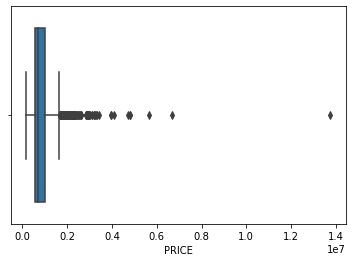

In [9]:
sns.boxplot(x='PRICE',data=sold)
plt.show()

After delete the outliers, we can see the distribution of price are more like normal distribution.

You dropped 97 rows.
Dataset has 2328 rows, 19 columns.


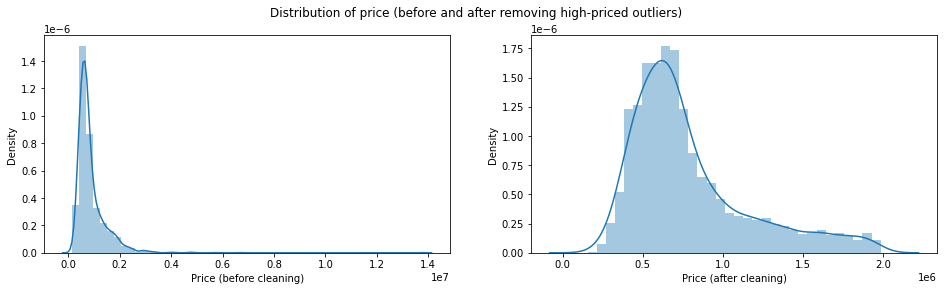

In [10]:
fig, axs = plt.subplots(ncols=2, figsize=(16, 4))
fig.suptitle('Distribution of price (before and after removing high-priced outliers)')

data = sold.copy()
target = 'PRICE'
# Before cleaning
x_axis = data[target].dropna()
sns.distplot(pd.Series(x_axis, name='Price (before cleaning)'), ax=axs[0])

# Remove where price > 2000000
condition = data[(data[target] < 2000000)]
rows_to_drop = np.delete(data.index,condition.index)
print("You dropped {} rows.".format(rows_to_drop.shape[0]))
trainc = data.copy()
trainc = trainc.drop(rows_to_drop, axis=0)
print("Dataset has {} rows, {} columns.".format(*trainc.shape))
#After cleaning
x_axis = trainc[target].dropna()
sns.distplot(pd.Series(x_axis, name='Price (after cleaning)'), ax=axs[1])
sold = sold[sold['PRICE'] < 2000000]
onsale = onsale[onsale['PRICE'] < 2000000];

After cleaning target column’s outlier, check the boxplot of ‘BEDS’ and find some residuals have 0 bed which has no sense. Therefore, I delete BEDS=0 rows.

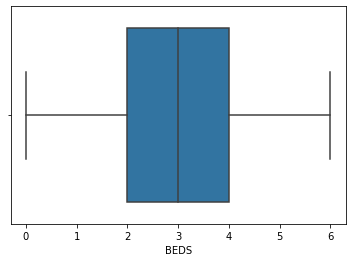

In [11]:
sns.boxplot(x='BEDS',data=sold)
plt.show()

In [12]:
sold = sold[sold['BEDS']!=0]
onsale = onsale[onsale['BEDS']!=0]

Next step is to check the outlier of BATHS by using boxplot of the relationship between BATHS and PRICE. Some BATHS are fraction probably because some one is smaller than normal bathroom’s size, so I prefer to keep these fraction numbers. 

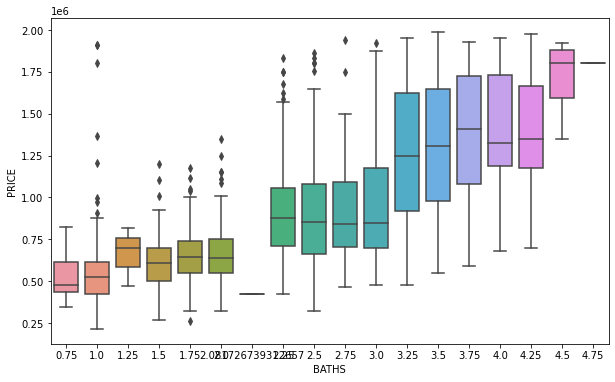

In [13]:
fig = plt.figure(figsize=(10,6))
sns.boxplot(x='BATHS',y='PRICE',data=sold)
plt.show()

 **(2) Features Selection**
 
After checking the distribution of objective features, I found ‘SALETYPE','PROPERTY TYPE','STATE' only has one unique group, so we do not need to keep them to fit into machine learning models since there are no differences inside of these features. 'URL' and 'ADDRESS' are useless for our modelling because URL is highly related to address and all of them are highly related to LONGITUDE and LATITUDE.


In [14]:
ob_col = sold.select_dtypes(include = 'object').columns
for col in ob_col:
    display(pd.DataFrame({col: sold[col].value_counts(),"Ratio": 100 * sold[col].value_counts() / len(sold)})) 

,SALETYPE,Ratio
PAST SALE,2291,100.0


,PROPERTY TYPE,Ratio
Single Family Residential,2291,100.0


,ADDRESS,Ratio
5458 17th Ave SW,2,0.087298
1407 S 99th St,2,0.087298
10001 46th Ave S,2,0.087298
2760 SW Holden St #4,2,0.087298
2150 32nd Ave W,2,0.087298
...,...,...
2829 SW 106th,1,0.043649
9552 Evanston Ave N,1,0.043649
652 NW 51st St,1,0.043649
1040 Lakeview Blvd E,1,0.043649


,CITY,Ratio
Seattle,2283,99.650808
Shoreline,4,0.174596
Lake Forest Park,2,0.087298
Burien,1,0.043649
Kent,1,0.043649


,STATE,Ratio
WA,2291,100.0


,URL,Ratio
http://www.redfin.com/WA/Seattle/14333-Dayton-Ave-N-98133/home/101832,2,0.087298
http://www.redfin.com/WA/Seattle/7307-24th-Ave-NE-98115/home/309034,2,0.087298
http://www.redfin.com/WA/Seattle/5120-SW-Olga-St-98116/home/149743,2,0.087298
http://www.redfin.com/WA/Seattle/6508-16th-Ave-SW-98106/home/161456,2,0.087298
http://www.redfin.com/WA/Seattle/9033-11th-Ave-SW-98106/home/476365,2,0.087298
...,...,...
http://www.redfin.com/WA/Seattle/5312-Beach-Dr-SW-98136/home/153938,1,0.043649
http://www.redfin.com/WA/Seattle/5209-33rd-Ave-S-98118/home/479319,1,0.043649
http://www.redfin.com/WA/Seattle/3512-NE-134th-St-98125/home/110821,1,0.043649
http://www.redfin.com/WA/Seattle/7752-36th-Ave-NE-98115/home/317913,1,0.043649


In [15]:
sold.drop(['SALETYPE','PROPERTY TYPE','ADDRESS','STATE','URL'],axis=1,inplace=True)
onsale.drop(['PROPERTY TYPE','ADDRESS','STATE'],axis=1,inplace=True)

In [16]:
from sklearn.preprocessing import LabelEncoder
labelencoder = LabelEncoder()
sold["CITY"] = labelencoder.fit_transform(sold["CITY"])
onsale["CITY"] = labelencoder.fit_transform(onsale["CITY"])

To predict house sale price, I try to find the most relevant explanatory variables. From the person correlation table of sold dataset, I checked the PRICE column’s score with other independent features and sorted it. 

In [17]:
sold_corr = sold.corr()
sold_corr
sold_corr.style.background_gradient(cmap='coolwarm', axis=None)

,CITY,ZIPCODE,PRICE,BEDS,BATHS,SQFT,LOTSIZE,YEARBUILT,DAYSONMARKET,PPSQFT,HOA,LATITUDE,LONGITUDE
CITY,1.000000,-0.008435,-0.024062,-0.049493,-0.037077,-0.043891,-0.089315,-0.024272,0.046549,0.017618,-0.026890,0.021201,0.000075
ZIPCODE,-0.008435,1.000000,-0.015413,0.028429,0.006209,0.024467,0.044454,0.007863,0.004435,-0.070945,-0.012255,-0.049017,0.017644
PRICE,-0.024062,-0.015413,1.000000,0.575083,0.700609,0.827488,-0.020025,0.565113,-0.030235,0.128365,0.000182,0.285801,-0.144755
BEDS,-0.049493,0.028429,0.575083,1.000000,0.746899,0.782129,0.029206,0.619488,-0.007933,-0.425305,0.041846,-0.000796,0.024424
BATHS,-0.037077,0.006209,0.700609,0.746899,1.000000,0.842572,-0.036264,0.764062,-0.019259,-0.332091,0.092195,0.036342,-0.021036
SQFT,-0.043891,0.024467,0.827488,0.782129,0.842572,1.000000,0.042753,0.692051,-0.014733,-0.375998,0.055284,0.079045,-0.042439
LOTSIZE,-0.089315,0.044454,-0.020025,0.029206,-0.036264,0.042753,1.000000,-0.075517,0.022788,-0.078718,0.336011,-0.054753,0.076676
YEARBUILT,-0.024272,0.007863,0.565113,0.619488,0.764062,0.692051,-0.075517,1.000000,-0.019499,-0.306351,0.111275,-0.015026,-0.011745
DAYSONMARKET,0.046549,0.004435,-0.030235,-0.007933,-0.019259,-0.014733,0.022788,-0.019499,1.000000,-0.033359,-0.012227,0.026404,-0.054421
PPSQFT,0.017618,-0.070945,0.128365,-0.425305,-0.332091,-0.375998,-0.078718,-0.306351,-0.033359,1.000000,-0.075755,0.312187,-0.163708


<Figure size 1440x720 with 0 Axes>

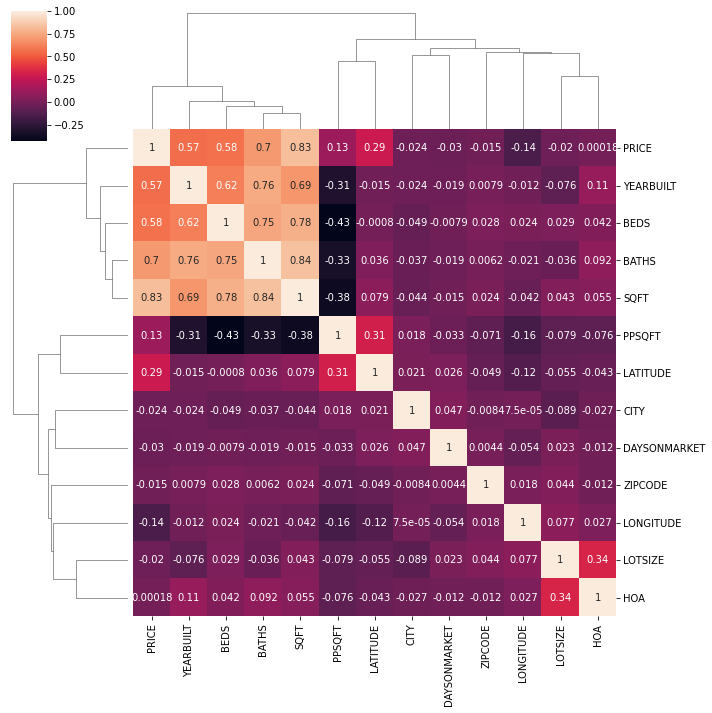

In [18]:
plt.figure(figsize=(20,10))
sns.clustermap(sold_corr,annot = True)
plt.show();

From the sort values result, I chose the most 4 strongest relations with target ‘PRICE’ which are 'SQFT','BATHS','BEDS','YEARBUILT'. I conjected the signs of these coefficients are all positive.

In [19]:
sold_corr['PRICE'].sort_values(ascending=False)

PRICE           1.000000
SQFT            0.827488
BATHS           0.700609
BEDS            0.575083
YEARBUILT       0.565113
LATITUDE        0.285801
PPSQFT          0.128365
HOA             0.000182
ZIPCODE        -0.015413
LOTSIZE        -0.020025
CITY           -0.024062
DAYSONMARKET   -0.030235
LONGITUDE      -0.144755
Name: PRICE, dtype: float64

In [20]:
features = ['SQFT','BATHS','BEDS','YEARBUILT']

After Mapping and exploring the sold house data. I found spatial patterns in PRICE and $/SQUARE FEET.  To be specifically, I used ArcGIS Online to map the spatial patterns in PRICE and SQET and found the patterns of PRICE and SQUARE FEET are similar in the middle of the statex, which are higher and bigger around Capitol Hill.

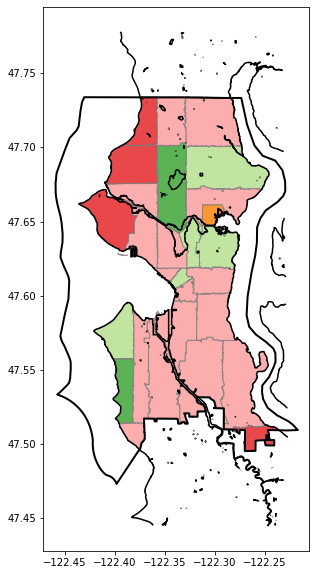

In [21]:
# load seattle shape
city = gpd.read_file('border/Municipal_Boundaries.shp')
water = gpd.read_file('border/City_of_Seattle_Shoreline.shp')
zip_codes_gdf = gpd.read_file('border/Zip_Codes.shp')
seattle = city.loc[city['CITYNAME'] == 'Seattle']
seattle = seattle.reset_index()
seattle_shp = seattle.loc[0, 'geometry']
seattle_zips = zip_codes_gdf.intersection(seattle_shp)

fig, ax = plt.subplots(figsize=(10,10))
water.plot(ax=ax, color='black')
seattle_zips.plot(ax=ax, cmap='Paired', alpha=.8, edgecolor='gray')
seattle.plot(ax=ax, color='#00000000', edgecolor='black', linewidth=2);

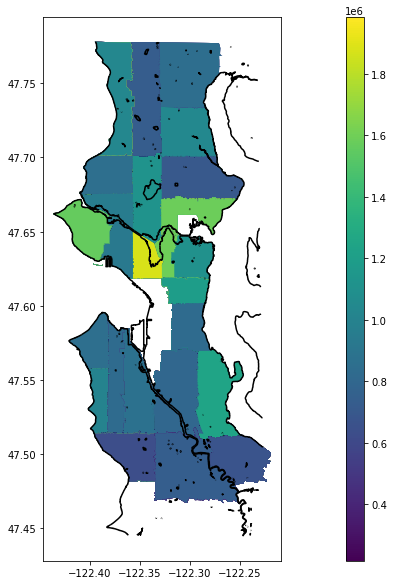

In [22]:
zip_codes_gdf = zip_codes_gdf.drop('ZIPCODE',axis=1)
zip_codes_gdf = zip_codes_gdf.rename(columns={'ZIP':'ZIPCODE'})
sold_zip = zip_codes_gdf.merge(sold, on='ZIPCODE')
from mpl_toolkits.axes_grid1 import make_axes_locatable

fig, ax = plt.subplots(figsize=(10,10))
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)
water.plot(ax=ax, color='black')
sold_zip.plot(column='PRICE', ax=ax, 
                      legend=True, cax=cax);

## V. Methodology 

**(1) Linear Regression Model**

I developed a linear regression model as baseline to predict house sale price based on the sold house dataset (sea_sold.csv). My explanatory variables are SQFT, BATHS, BEDS and YEARBUILT. From the result below, we can see 70% target can be successfully predicted by our explanatory variables.

In [23]:
x = sold[features].values
y = sold['PRICE'].values
X = sm.add_constant(x)
results = sm.OLS(y, X).fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.700
Model:                            OLS   Adj. R-squared:                  0.699
Method:                 Least Squares   F-statistic:                     1331.
Date:                Sat, 24 Apr 2021   Prob (F-statistic):               0.00
Time:                        15:38:17   Log-Likelihood:                -31253.
No. Observations:                2291   AIC:                         6.252e+04
Df Residuals:                    2286   BIC:                         6.254e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       4.935e+05   3.32e+05      1.485      0.1

In [24]:
results_as_html = results.summary().tables[0].as_html()
pd.read_html(results_as_html, header=0, index_col=0)[0].to_excel('output1.xlsx')
results_as_html = results.summary().tables[1].as_html()
pd.read_html(results_as_html, header=0, index_col=0)[0].to_excel('output2.xlsx')
results_as_html = results.summary().tables[2].as_html()
pd.read_html(results_as_html, header=0, index_col=0)[0].to_excel('output3.xlsx')

In [25]:
sold['ols_residuals'] = results.resid
sold.to_csv('ols_residuals.csv')

I also visualized the residuals on the map and noticed spatial patterns of the residuals. The higher residuals concentrate some areas. But for south west area the predictions are not so accurate.


**(2) Geographically Weighted Regression (GWR) Model**

I Built a Geographically Weighted Regression (GWR) model with the same explanatory variables as in the previous step, based on the sold house dataset (sea_sold.csv). I chose bis-square since other in kernels all observations retain non-zero weight, regardless of how far they are from the calibration location. The default kernel is to use a bi-square kernel. 89% of target can be explained by features which is much better than the OLS regression. Moreover, comparing the Regression above, features have different importance. 

In [26]:
df = sold.copy()
g_y = df['PRICE'].values.reshape((-1,1))
g_X = df[features].values
u = df['LONGITUDE']
v = df['LATITUDE']
g_coords = list(zip(u,v))
g1_X = (g_X - g_X.mean(axis=0)) / g_X.std(axis=0)
g_y = g_y.reshape((-1,1))
g1_y = (g_y - g_y.mean(axis=0)) / g_y.std(axis=0)

In [27]:
# Select a bandwidth
gwr_selector = Sel_BW(g_coords, g1_y, g1_X)
gwr_bw = gwr_selector.search(bw_min=2)
print(gwr_bw)

85.0


In [28]:
# Fit the model
gwr_model = GWR(g_coords, g1_y, g1_X, gwr_bw)
gwr_results = gwr_model.fit()

In [29]:
gwr_results.summary()

Model type                                                         Gaussian
Number of observations:                                                2291
Number of covariates:                                                     5

Global Regression Results
---------------------------------------------------------------------------
Residual sum of squares:                                            688.143
Log-likelihood:                                                   -1873.041
AIC:                                                               3756.082
AICc:                                                              3758.119
BIC:                                                             -16998.053
R2:                                                                   0.700
Adj. R2:                                                              0.699

Variable                              Est.         SE  t(Est/SE)    p-value
------------------------------- ---------- ---------- ------

___________________

I also visualized the local R2 and estimated coefficients on map. The patterns of R2 and residual are similar distribution. In the south, SQFT and BATHS pattern are similar while in the middle of state are different. The patterns of BEDS and YEARBUILT are similar except in the center of the WA state. So far GWR modelled relationships between sqft_living and price with a line. A unit increase in house’s size corresponds to an increase in house price.

In [30]:
#!pip install arcgis

In [31]:
from arcgis.features import GeoAccessor, GeoSeriesAccessor
from arcgis.features import FeatureLayer
df = pd.DataFrame.spatial.from_xy(df=sold, x_column="LONGITUDE",y_column="LATITUDE", sr=4326)
df['LocalR2'] = gwr_results.localR2
df.spatial.plot(renderer_type='c', method='esriClassifyNaturalBreaks', class_count=20, col='LocalR2')

MapView(layout=Layout(height='400px', width='100%'))

In [32]:
df['X0'] = gwr_results.params[:,0]
df.spatial.plot(renderer_type='c', method='esriClassifyNaturalBreaks', class_count=20, col='X0')

MapView(layout=Layout(height='400px', width='100%'))

In [ ]:
df['X1'] = gwr_results.params[:,1]
df.spatial.plot(renderer_type='c', method='esriClassifyNaturalBreaks', class_count=20, col='X1')

In [ ]:
df['X2'] = gwr_results.params[:,2]
df.spatial.plot(renderer_type='c', method='esriClassifyNaturalBreaks', class_count=20, col='X2')

In [ ]:
df['X3'] = gwr_results.params[:,3]
df.spatial.plot(renderer_type='c', method='esriClassifyNaturalBreaks', class_count=20, col='X3')

___________________

**(3) RandomForest Regression**

Random Forest Regression model is not affected by multicollinearity, because it is not a linear model, and it can model relationships between a vast number of predictor variables (spatial and non-spatial property characteristics) and a target variable (sale price). The model performance for testing set RMSE is 200441.18, R2 score is 0.71 which is worse than GWR model and better than OLS model. The most important feature is SQFT, the least important one is BEDS.

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor

X = df[features]
y = df['PRICE']
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.2,random_state=5)

from sklearn.metrics import mean_squared_error,r2_score
rf = RandomForestRegressor()
rf.fit(X_train,y_train)
y_test_predict = rf.predict(X_test)
rmse = (np.sqrt(mean_squared_error(y_test,y_test_predict)))
r2 = r2_score(y_test,y_test_predict)
print('The model performance for testing set')
print('\n RMSE is {}'.format(rmse))
print('\n R2 score is {}'.format(r2))

In [ ]:
def feature_importance(model, trainData, display_n_rows):
    """Display feature importance & weighting for Regression based model"""
    fi = model.feature_importances_* 100
    feat_imp = pd.DataFrame(list(zip(fi,trainData.columns.values)))
    feat_imp = feat_imp.sort_values(by=0, axis=0, ascending=False)
    feat_imp.columns = ['importance %', 'feature']
    return feat_imp
feature_importance(rf, X_train, 30)

In [ ]:
feature_importance(rf, X_train, 30).set_index('feature').plot.bar()
plt.title('Feature Importance with respect to RandomForestRegressor')
plt.show()

**(4) Predict by using the best model**

In [ ]:
pred0_X = onsale[features].values  
u0 = onsale['LONGITUDE'] 
v0 = onsale['LATITUDE'] 

pred_coords = np.array(list(zip(u0,v0)))

pred1_X = (pred0_X - g_X.mean(axis=0)) / g_X.std(axis=0)
pred_results = gwr_model.predict(pred_coords, pred1_X)
pred_results.predictions 

In [ ]:
pred_y = pred_results.predictions * g_y.std(axis=0) + g_y.mean(axis=0)
pred_y 

In [ ]:
onsale['predict'] = pred_y
onsale.to_csv('result.csv')

Finally, I plot the time-series of PRICE and $/SQUARE FEET of the data in sea_sold.csv. Both of PRICE and SQFT time series are not stational and if we want to predict the price by time series models (ARIMA etc.) in the future, we should make them stational by First Difference or Seasonal Adjustment or Seasonal Difference or by using all the method above until it becomes stational.

In [ ]:
dfnew = sold[['SOLDDATE','PRICE','SQFT']].set_index('SOLDDATE')
dfnew.head()

In [ ]:
dfnew['PRICE'].plot()
plt.title('PRICE VS DATE');

In [ ]:
from statsmodels.tsa.stattools import adfuller   #Dickey-Fuller test
def test_stationarity(timeseries):
    rolmean = timeseries.rolling(12).mean()
    rolstd = timeseries.rolling(12).std()
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')  
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)
test_stationarity(dfnew['PRICE'])

In [ ]:
dfnew['SQFT'].plot()
plt.title('SQFT VS DATE');

In [ ]:
test_stationarity(dfnew['SQFT'])

## VI. Conclusion and Limitation

Visualization is a vital part of regression analysis to understand important variables and to explore relationships between variables. Then I used Python and ArcGIS to try to tell the spatial patterns. We can see the obvious patterns from map.

When comparing OLS, Forest-Based Regression and the GWR models, GWR model has better performance. GWR defines a linear model that varies from location to location, so is better suited to capture spatial variations in relation to price, where the predicted house price is reasonable for the 	. 

GWR solves a linear regression model at every location where predictor variables from nearby neighbours are weighted with a spatial kernel, with near neighbours having more impact on the regression model than distant neighbours. GWR coefficient surfaces are also an effective means to visualize spatial variation of relationship between an explanatory variable and a target variable. 

Finally, Random Forest Regression produces valuable diagnostics such as the variable importance 
plot that quantifies the impact of an explanatory variable in the regression model. 

Because the price of real estate is also highly related to time. We also need to put time into consideration and perform different areas and spatial groups time series prediction. In the last part of the report, I used the best model (GWR) to predict on sale real estate price, simply performed Dickey-Fuller Test on the whole predictions and found the time series is not stational. The next step is to make the dataset stational or separate the dataset into different spatial groups to try the test again. For time series prediction, we only need time feature and past days’ price o predict the price. After combining the spatial model and time series model, we would declaim more interest insights.

## Reference 

Can, A., 1992. Specification and estimation of hedonic housing price models. Regional Science and Urban Economics, 22(3), pp.453-474.

Lu, B., Charlton, M. and Fotheringhama, A., 2011. Geographically Weighted Regression Using a Non-Euclidean Distance Metric with a Study on London House Price Data. Procedia Environmental Sciences, 7, pp.92-97.

Huang, B., Wu, B. and Barry, M., 2010. Geographically and temporally weighted regression for modeling spatio-temporal variation in house prices. International Journal of Geographical Information Science, 24(3), pp.383-401.

Geng, J., 2011. Geographically Weighted Regression model (GWR) based spatial analysis of house price in Shenzhen. In: 19thInternational Conference on Geoinformatics. Shanghai.	
